### STROKE PREDICTION



**Data set:** https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data

**Target Variable:**
stroke: Binary variable indicating whether having stroke (1) or No stroke (0).


### **Problem Definition:**

The task is to develop a predictive model to determine the likelihood of a patient experiencing a stroke based on various input parameters. Given a dataset containing information such as gender, age, presence of hypertension, heart disease, marital status, occupation, residence type, average glucose level, body mass index (BMI), and smoking status, the objective is to predict whether a patient is susceptible to a stroke or not.The problem can be formulated as a binary classification task, where the target variable is whether a stroke occurred (1) or not (0). The model will be trained on historical data with known stroke outcomes to learn patterns and relationships between the input features and stroke incidence. Once trained, the model will be capable of predicting the likelihood of stroke for new, unseen patient data.This predictive model can potentially aid healthcare professionals in identifying individuals at higher risk of stroke, allowing for timely intervention and preventive measures to reduce the burden of stroke-related morbidity and mortality.


### **Business Problem and Implications:**

The business problem that can be addressed using the stroke prediction dataset revolves around the healthcare sector's need to enhance stroke prevention strategies. This challenge primarily affects healthcare providers, insurance companies, patients, and their families. For healthcare providers and insurance companies, the early identification of high-risk patients enables the implementation of targeted preventative measures, potentially leading to significant cost savings by reducing the need for expensive emergency treatments and long-term care associated with stroke recovery. For patients and their families, the implications are profoundly personal; early intervention can mean the difference between life and death, significantly reduce the severity of a stroke's aftermath, or even prevent the occurrence entirely.

The financial implications of a potential solution include reduced healthcare costs associated with treating stroke and its long-term effects, such as rehabilitation and disability accommodations. Furthermore, insurance companies could see lower payout rates for stroke-related claims by investing in preventive care and personalized health monitoring for high-risk individuals. Socially, the benefits are immense; improved quality of life for those at risk, reduced emotional and financial strain on families, and a healthier population overall. Moreover, by leveraging such analytics, public health initiatives can be more effectively directed, and awareness campaigns can be tailored to those at the highest risk, fostering a more health-conscious society.

### **Objective:**

The objective of this project is to develop a predictive model to identify individuals who are at risk of experiencing a stroke based on their demographic information, medical history, and lifestyle factors. By analyzing a dataset containing features such as gender, age, presence of various diseases, smoking status, and other relevant parameters, the goal is to build a robust machine learning model that can accurately classify individuals as either high or low risk for stroke.


### **Import Necessary Packages:**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import tree

### **Loading Dataset**

In [ ]:
from google.colab import files
import io
import pandas as pd

# Try to upload the file, handling potential errors
try:
  uploaded = files.upload()
  strokedetection = pd.read_csv(io.BytesIO(uploaded['stroke.csv']))  # Use the actual filename
except KeyError:
  print("Please upload the 'stroke.csv' file.")
except Exception as e:
  print(f"An error occurred: {e}")

Saving stroke.csv to stroke (3).csv
Please upload the 'stroke.csv' file.


In [ ]:
strokedetection.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# Assess target variable distribution
target_distribution = strokedetection['stroke'].value_counts()
print(target_distribution)

stroke
0    4861
1     249
Name: count, dtype: int64


<Axes: >

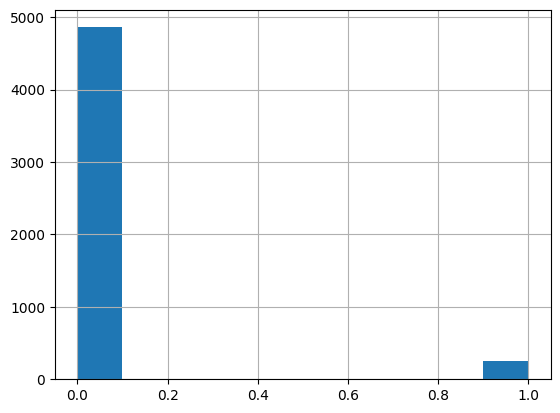

In [ ]:
strokedetection.stroke.hist()


The graphs illustrate the relationship with the target variable "Stroke."

Upon examination, it's clear that the distribution of stroke cases skews heavily towards negative outcomes. Specifically, there are approximately 4861 instances of negative outcomes compared to only 249 instances of positive results.

<Axes: >

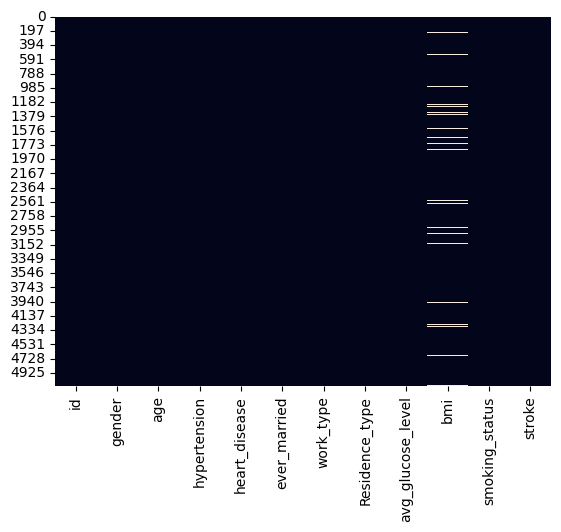

In [ ]:
# Explore missing values

sns.heatmap(strokedetection.isnull(), cbar=False)

In [ ]:
strokedetection

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


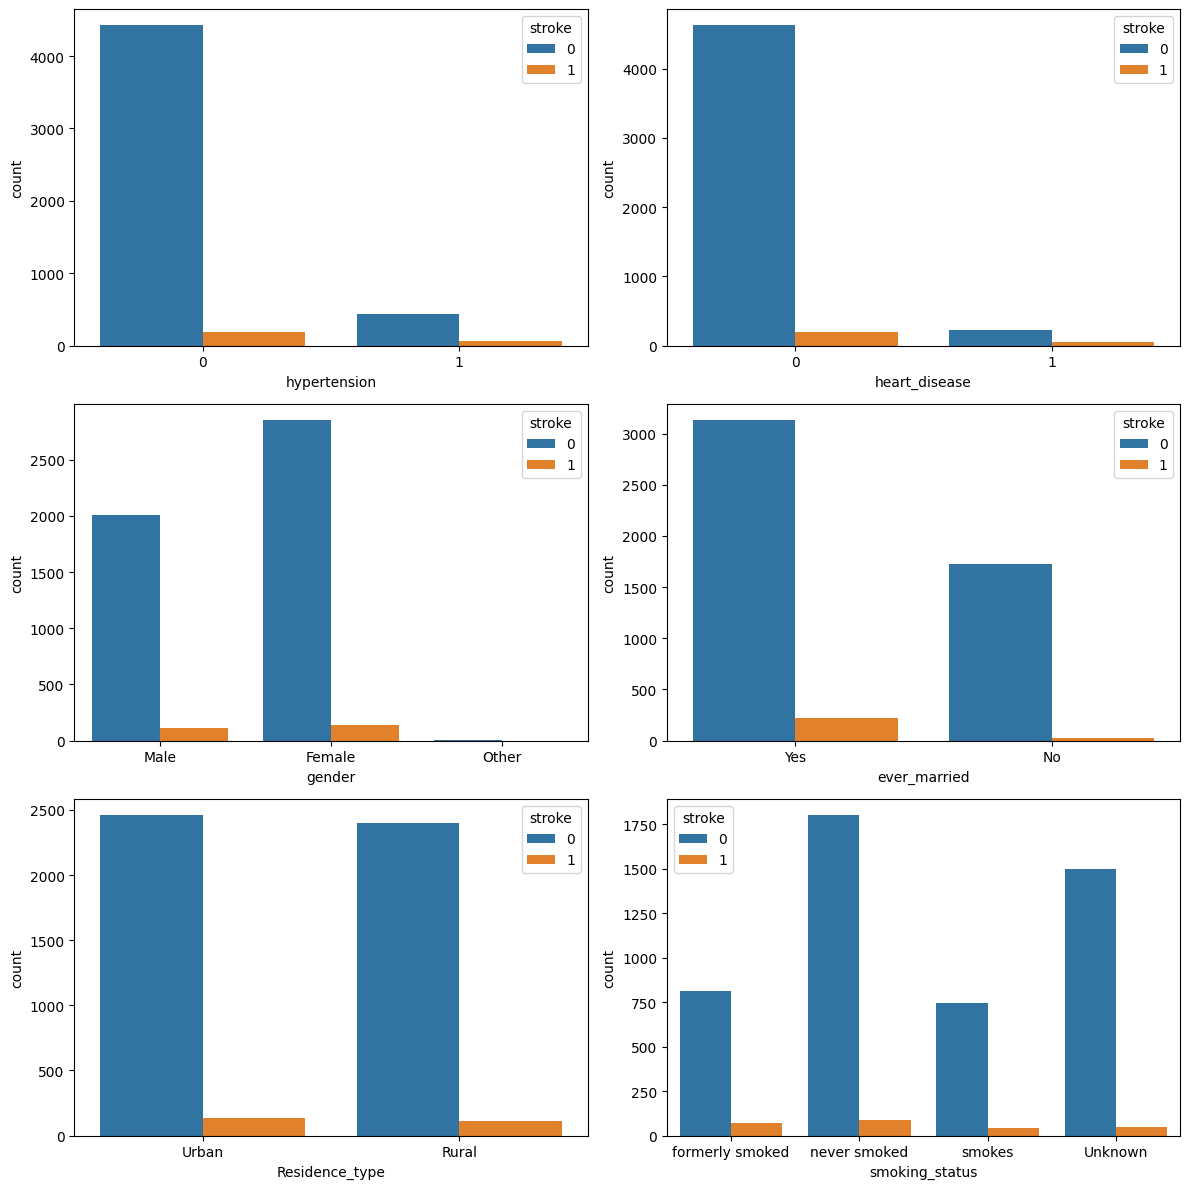

In [ ]:
# Bar chart for binary variables
binary_vars = ['hypertension', 'heart_disease', 'gender', 'ever_married', 'Residence_type', 'smoking_status']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for var, ax in zip(binary_vars, axes.flatten()):
    sns.countplot(x=var, hue='stroke', data=strokedetection, ax=ax)
plt.tight_layout()
plt.show()

The graphs illustrate the relationship between the target variable "Stroke" along with the distribution of variables like Hypertension, Heart_disease, Gender, Ever_married, Residence_type, and Smoking_status concerning the target variable.

It is evident from all graphs that these variables exhibit sparse distributions, predominantly impacting a negative outcome of Stroke. A closer examination of the graphs depicting positive stroke outcomes reveals a higher risk associated with certain demographics and health conditions. Specifically, the risk of stroke appears elevated among married individuals, women, urban residents, and those with heart disease. These distinctions are clearly depicted in the graphical representations.









In [ ]:
#impute missing values
median_bmi = strokedetection['bmi'].median()

# Replace NaN values in the 'bmi' column with the median
strokedetection['bmi'].fillna(value=median_bmi, inplace=True)

<ipython-input-17-6b2ef160c456>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  strokedetection['bmi'].fillna(value=median_bmi, inplace=True)


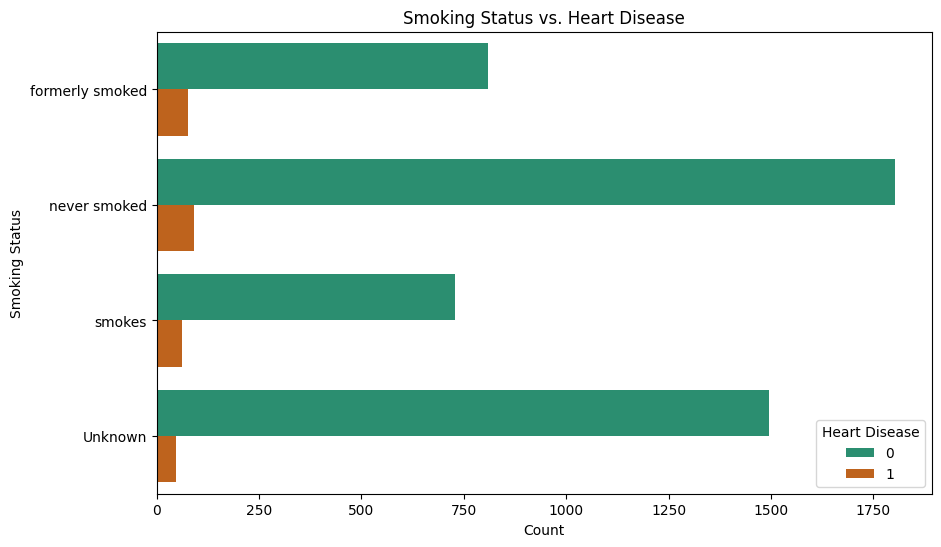

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y='smoking_status', hue='heart_disease', data=strokedetection, palette='Dark2')
plt.xlabel('Count')
plt.ylabel('Smoking Status')
plt.title('Smoking Status vs. Heart Disease')
plt.legend(title='Heart Disease', loc='lower right')
plt.show()

The graphs depict the relationship between the target variable "Stroke" and the distribution of the "Heart_disease" variable concerning the target.

Observing the data, it's notable that both the Stroke variable and Heart disease show a higher distribution of negative outcomes. However, the risk for a positive outcome is more apparent among individuals who have never smoked or were former smokers.

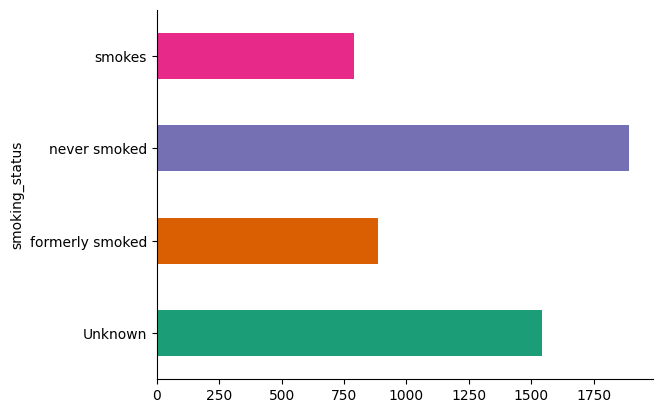

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
strokedetection.groupby('smoking_status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


The graphs illustrate the relationship with the predictor variable "Smoking status."

Upon observation, it's noteworthy that the dataset contains a higher number of rows with the "Never smoked" status. Interestingly, regarding the distribution of the target variable, this predictor variable appears to have a more significant influence on positive stroke outcomes.

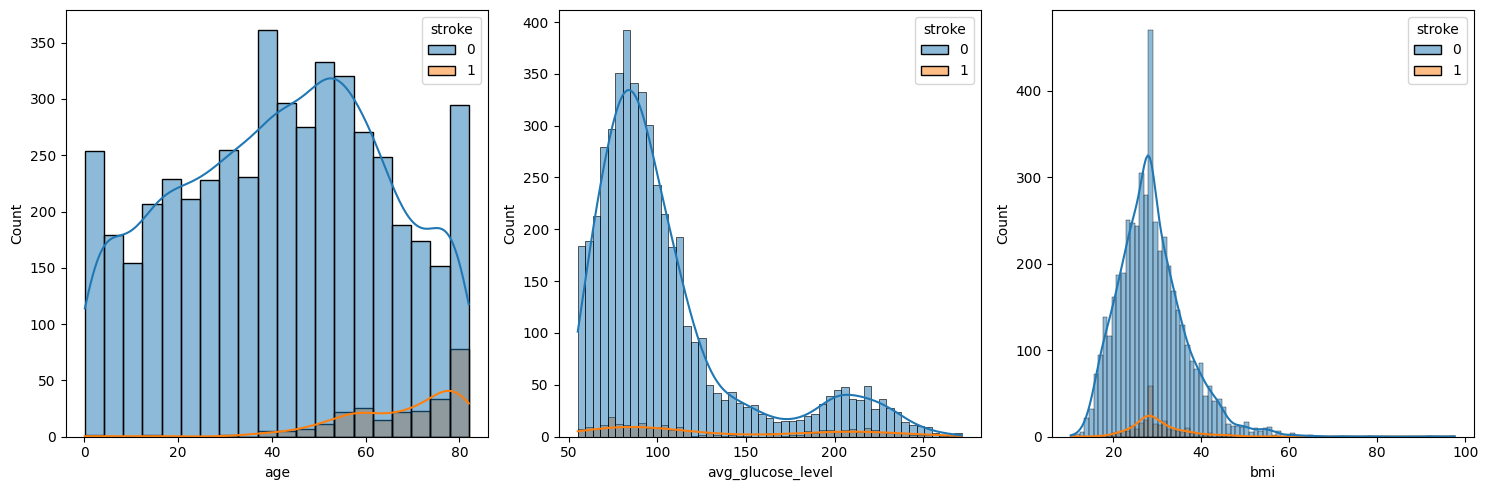

In [ ]:
# Histograms for continuous variables
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
continuous_vars = ['age', 'avg_glucose_level', 'bmi']
for var, ax in zip(continuous_vars, axes.flatten()):
    sns.histplot(data=strokedetection, x=var, hue='stroke', ax=ax, kde=True)
plt.tight_layout()
plt.show()


The graphs above illustrate the relationship between the target variable and predictor variables, highlighting how Age, Avg_glucose_level, and BMI are distributed based on the target variable.

Upon closer inspection, it's evident that these variables display sparse distributions, predominantly influencing a negative outcome of stroke. However, a more detailed analysis of the graphs portraying positive stroke outcomes reveals a heightened risk associated with specific demographics and health conditions. Particularly, the risk of stroke seems to increase among individuals aged 70 and older, those with Avg_glucose_level around 65-75, and BMI around 30. These distinctions are clearly depicted in the graphical representations.

Conversely, concerning adverse effects, individuals around the age of 45 exhibit the highest percentage of risk for not experiencing a stroke.

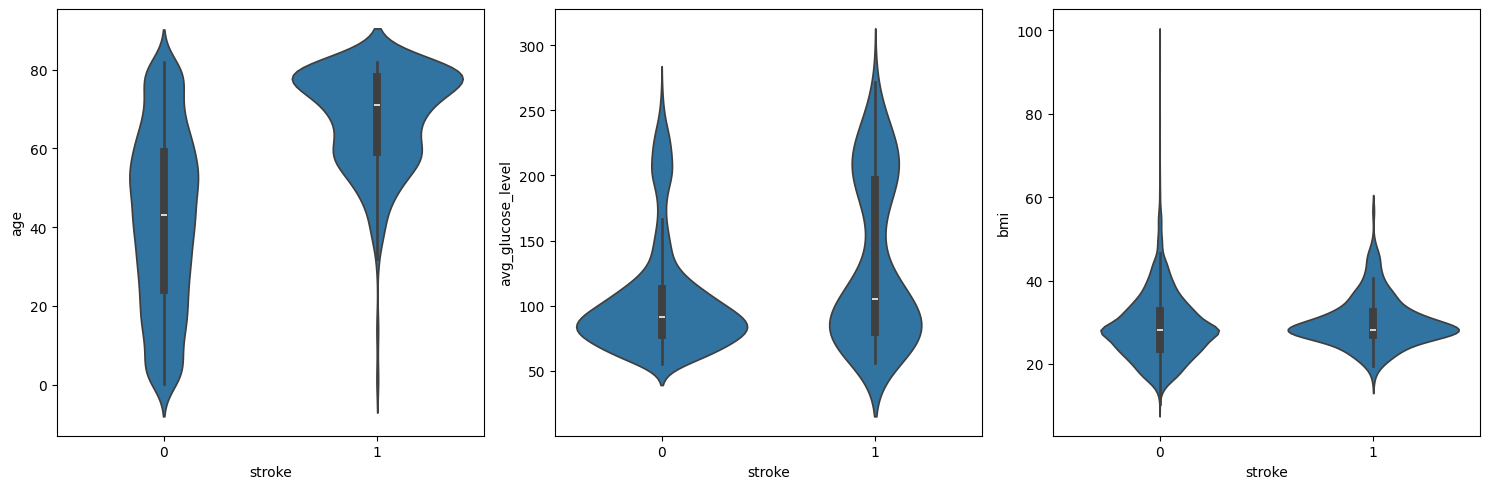

In [ ]:
# Violin Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for var, ax in zip(continuous_vars, axes.flatten()):
    sns.violinplot(x='stroke', y=var, data=strokedetection, ax=ax)
plt.tight_layout()
plt.show()

The graphs depict the distribution plots between the target variable and predictor variables, specifically Age, Avg_glucose_level, and BMI.

In this current graph, we observe a normal distribution for both Age and BMI variables across both Stroke outcomes. However, there are also outliers present, notably for the BMI variable and negative Stroke outcomes, as well as for the Age variable and positive Stroke outcomes.

In [ ]:
strokedetection = strokedetection.drop(['id'],axis=1) # Dropping uneccesary columns
smoking_status_to_remove = ['Unknown']
strokedetection.drop(strokedetection[strokedetection['smoking_status'].isin(smoking_status_to_remove)].index, inplace = True)  # Dropping unkown data in the smoking status column
strokedetection.drop(strokedetection[strokedetection['bmi'] > 65 ].index, inplace = True)  # Removing bmi outliers

In [ ]:
strokedetection.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
strokedetection = pd.get_dummies(strokedetection)

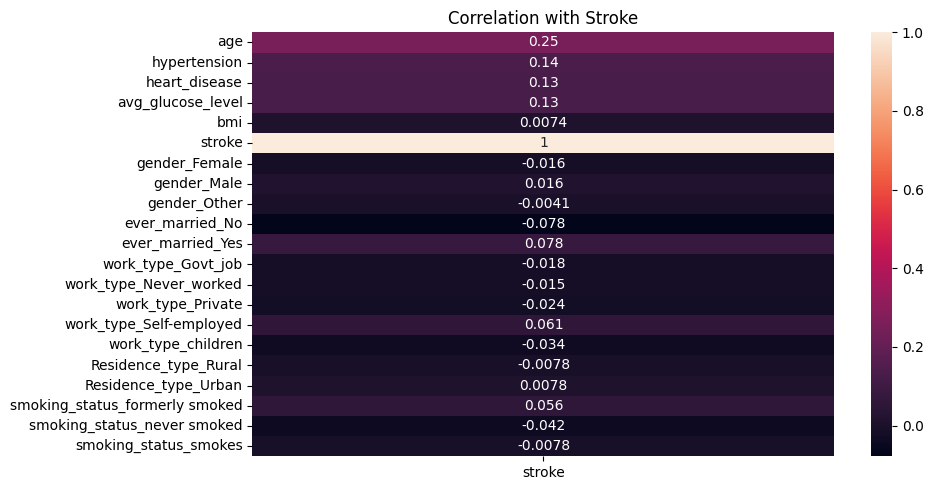

In [ ]:
plt.figure(figsize=(10,5))
corr_plot = sns.heatmap(strokedetection.corr()[['stroke']], annot=True)
plt.title('Correlation with Stroke')
plt.tight_layout()
plt.show()

In [ ]:
strokedetection.corr()['stroke'].sort_values(ascending=False)

,stroke
stroke,1.000000
age,0.250724
hypertension,0.135327
heart_disease,0.129299
avg_glucose_level,0.128845
ever_married_Yes,0.078074
work_type_Self-employed,0.060537
smoking_status_formerly smoked,0.055688
gender_Male,0.015758
Residence_type_Urban,0.007803


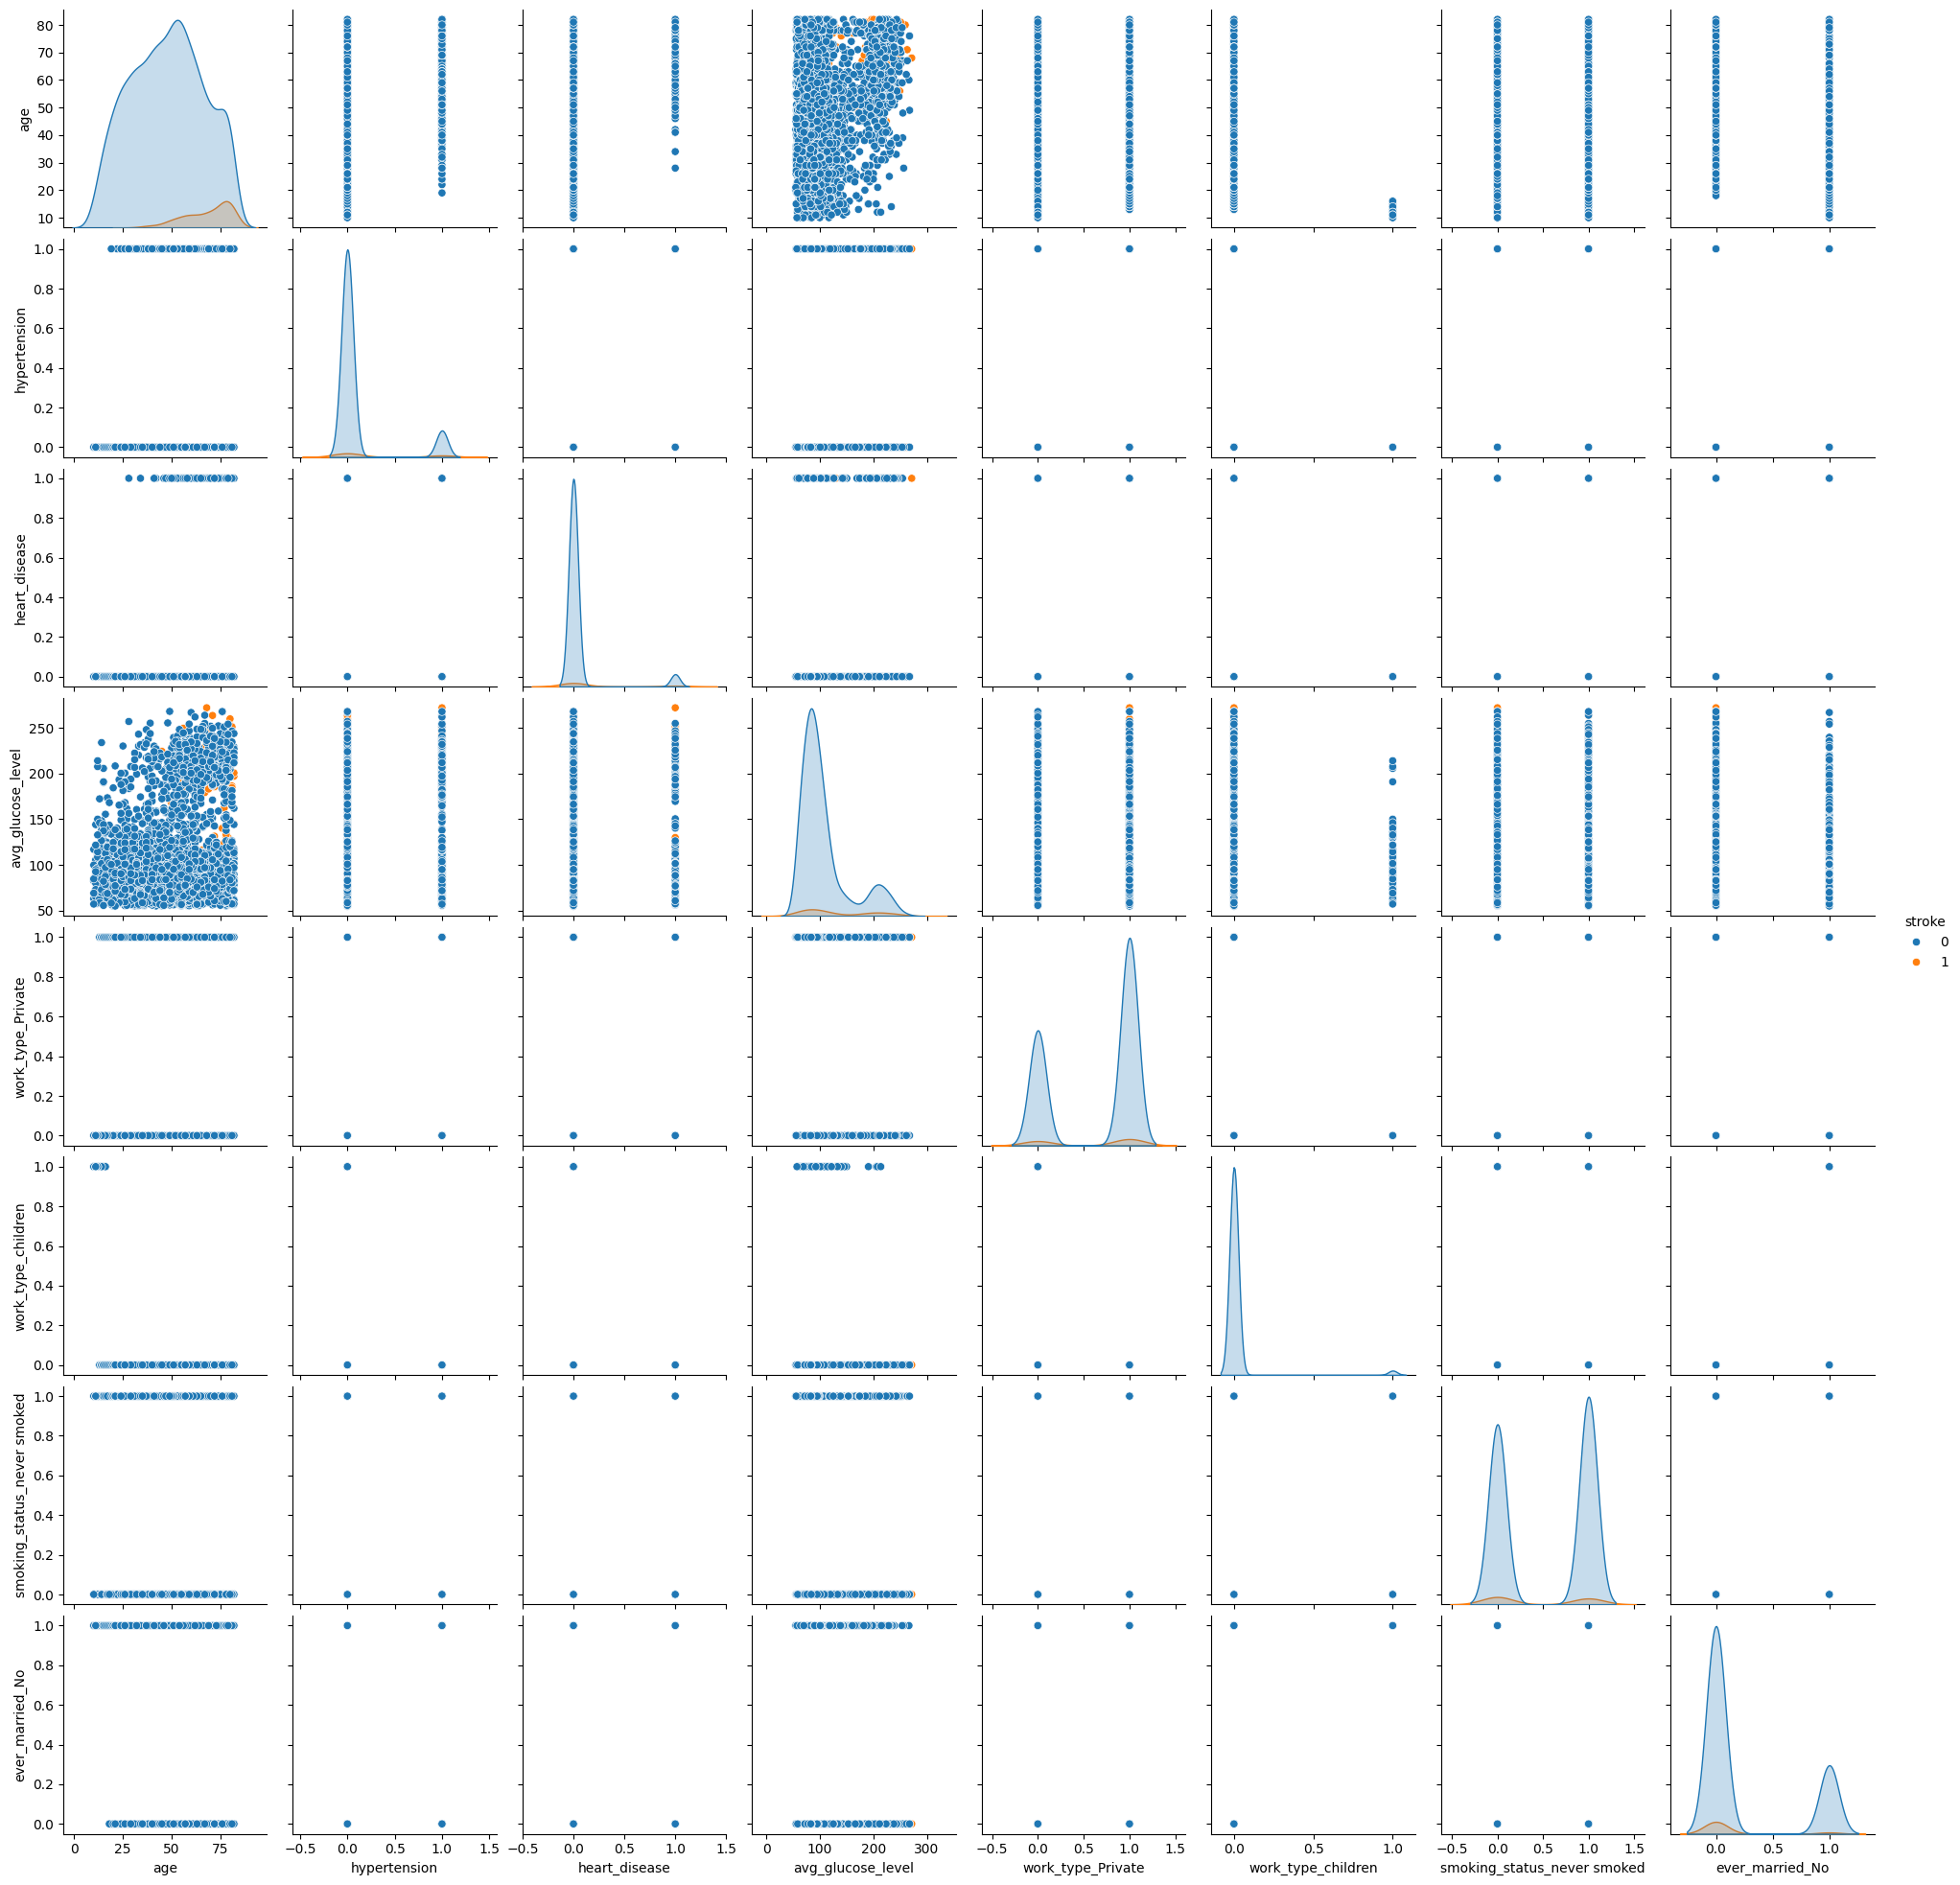

In [ ]:
sns.pairplot(strokedetection[['stroke','age','hypertension','heart_disease','avg_glucose_level','work_type_Private','work_type_children','smoking_status_never smoked','ever_married_No']],hue='stroke')

**PAIRPLOT EXPLAINATION:**

The pair plot provides a visual summary of potential associations between stroke incidence and five key health indicators: age, hypertension, heart disease, average glucose level, and BMI. Scatter plots for continuous variables suggest a higher occurrence of stroke among older individuals and those with elevated glucose levels and BMI. Binary health conditions—hypertension and heart disease—are visually depicted as clusters, indicating a possible higher stroke risk for affected individuals. The diagonal density plots highlight the distribution of each variable, revealing the overall data structure and potential outliers. This visual matrix serves as an exploratory tool indicating areas for deeper statistical analysis on stroke risk factors.

In summary, the scatter plots in this matrix suggest possible associations between higher age, BMI, and average glucose levels with the occurrence of strokes, as indicated by the density of orange points in higher value regions. Additionally, there appears to be a higher incidence of stroke among individuals with hypertension and heart disease.



In [ ]:
strokedetection.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000
mean,48.866124,0.124614,0.063991,108.979074,30.161605,0.056694
std,18.876123,0.330327,0.244771,48.270296,7.011524,0.231289
min,10.000000,0.000000,0.000000,55.120000,11.500000,0.000000
25%,34.000000,0.000000,0.000000,77.470000,25.400000,0.000000
50%,50.000000,0.000000,0.000000,92.650000,28.700000,0.000000
75%,63.000000,0.000000,0.000000,116.675000,33.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,64.800000,1.000000


In [ ]:
# Assess target variable distribution
target_distribution = strokedetection['stroke'].value_counts()
print(target_distribution)

stroke
0    3361
1     202
Name: count, dtype: int64


In [ ]:
strokedetection.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,False,True,False,False,...,False,False,True,False,False,False,True,True,False,False
1,61.0,0,0,202.21,28.1,1,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False
2,80.0,0,1,105.92,32.5,1,False,True,False,False,...,False,False,True,False,False,True,False,False,True,False
3,49.0,0,0,171.23,34.4,1,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
4,79.0,1,0,174.12,24.0,1,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False


In [ ]:
strokedetection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3563 entries, 0 to 5108
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             3563 non-null   float64
 1   hypertension                    3563 non-null   int64  
 2   heart_disease                   3563 non-null   int64  
 3   avg_glucose_level               3563 non-null   float64
 4   bmi                             3563 non-null   float64
 5   stroke                          3563 non-null   int64  
 6   gender_Female                   3563 non-null   bool   
 7   gender_Male                     3563 non-null   bool   
 8   gender_Other                    3563 non-null   bool   
 9   ever_married_No                 3563 non-null   bool   
 10  ever_married_Yes                3563 non-null   bool   
 11  work_type_Govt_job              3563 non-null   bool   
 12  work_type_Never_worked          3563 no

In [ ]:
strokedetection.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000
mean,48.866124,0.124614,0.063991,108.979074,30.161605,0.056694
std,18.876123,0.330327,0.244771,48.270296,7.011524,0.231289
min,10.000000,0.000000,0.000000,55.120000,11.500000,0.000000
25%,34.000000,0.000000,0.000000,77.470000,25.400000,0.000000
50%,50.000000,0.000000,0.000000,92.650000,28.700000,0.000000
75%,63.000000,0.000000,0.000000,116.675000,33.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,64.800000,1.000000


# Scaling the data

In [ ]:
scaler = MinMaxScaler() # Using MinMax Scaler to scale the data
X = strokedetection.drop('stroke', axis=1)
X_rescaled = scaler.fit_transform(X)
X_rescaled = pd.DataFrame(X_rescaled, columns=X.columns)

In [ ]:
X_rescaled.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.791667,0.0,1.0,0.801265,0.470919,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.708333,0.0,0.0,0.679023,0.311445,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.972222,0.0,1.0,0.234512,0.393996,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.541667,0.0,0.0,0.536008,0.429644,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.958333,1.0,0.0,0.549349,0.234522,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0



### **Developing Logistic Regression, kNN (optimize k), Random Forest, Boosted Tree, Naive Bayes Modelto predict chance of having stroke:**

# Logistic Regression

In [ ]:
y = strokedetection['stroke']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rescaled, y, test_size=0.3, random_state=42)

In [ ]:
logmodel = LogisticRegression(solver='liblinear', class_weight='balanced')

logmodel.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [ ]:
y_pred = logmodel.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(y_test,y_pred)

array([[718, 284],
       [ 19,  48]])

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      1002
           1       0.14      0.72      0.24        67

    accuracy                           0.72      1069
   macro avg       0.56      0.72      0.53      1069
weighted avg       0.92      0.72      0.79      1069



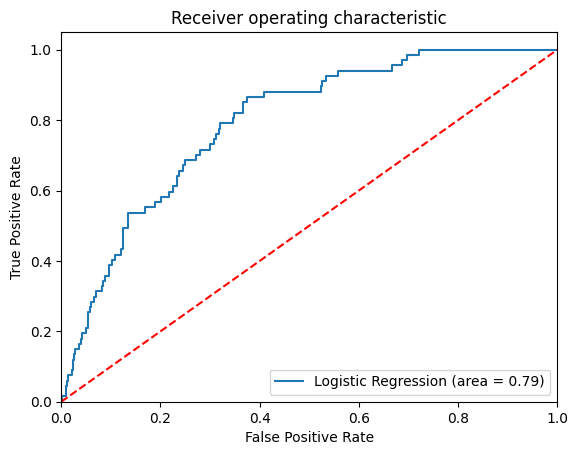

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

logit_roc_auc = roc_auc_score(y_test, logmodel.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# kNN Model

In [ ]:
X_rescaled.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000
mean,0.539807,0.124614,0.063991,0.248634,0.350124,0.605389,0.394331,0.000281,0.239966,0.760034,0.150154,0.003929,0.640472,0.186079,0.019366,0.491159,0.508841,0.248386,0.530452,0.221162
std,0.262168,0.330327,0.244771,0.222834,0.131548,0.488836,0.488775,0.016753,0.427123,0.427123,0.357273,0.062569,0.479930,0.389225,0.137826,0.499992,0.499992,0.432138,0.499142,0.415088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000,0.103176,0.260788,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.555556,0.000000,0.000000,0.173253,0.322702,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.736111,0.000000,0.000000,0.284161,0.418386,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:

# Determine the optimal value of k based on ROC AUC using cross-validation
max_K = 100
cv_scores = []

for K in range(1, max_K):
    knn = KNeighborsClassifier(n_neighbors=K)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring="roc_auc")
    cv_scores.append(scores.mean())


In [ ]:
cv_scores[:4]

[0.5287878700815953,
 0.5418904427703563,
 0.5324075910566174,
 0.5512547603856656]

In [ ]:
# Find the index of the maximum ROC AUC value
optimal_k_index = np.argmax(cv_scores)

# Retrieve the optimal k value
optimal_k = optimal_k_index + 1  # Adding 1 because K ranges from 1 to max_K, not from 0 to max_K-1

# Retrieve the maximum ROC AUC value
max_roc_auc = cv_scores[optimal_k_index]

# Print the results
print('Optimal k for maximum ROC AUC:', optimal_k)
print('Maximum ROC AUC:', max_roc_auc)


Optimal k for maximum ROC AUC: 92
Maximum ROC AUC: 0.7280101191632025


<Axes: >

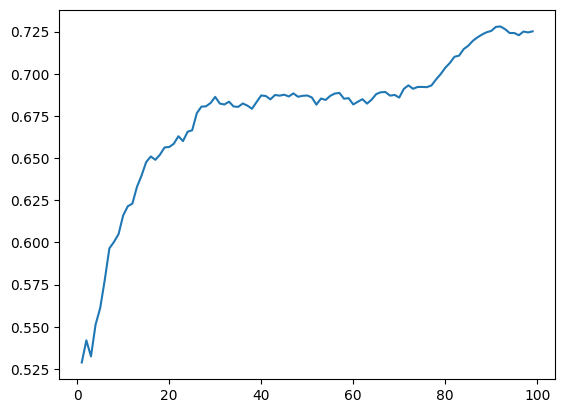

In [ ]:
sns.lineplot(x=range(1,max_K), y=cv_scores)

# Optimized kNN model with K=92

In [ ]:
knn = KNeighborsClassifier(n_neighbors=92, metric='euclidean',weights='distance')
knn.fit(X_train, y_train)


KNeighborsClassifier(metric='euclidean', n_neighbors=92, weights='distance')

In [ ]:

y_pred = knn.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1002    0]
 [  67    0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1002
           1       0.00      0.00      0.00        67

    accuracy                           0.94      1069
   macro avg       0.47      0.50      0.48      1069
weighted avg       0.88      0.94      0.91      1069



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import roc_auc_score

print('ROC AUC: ', roc_auc_score(y_test,y_pred))

ROC AUC:  0.5


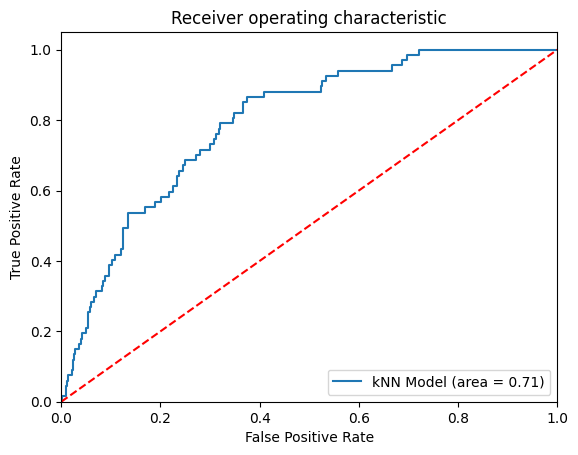

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

kNN_roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='kNN Model (area = %0.2f)' % kNN_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model  = RandomForestClassifier(max_depth=None, random_state=0)
rf_model.fit(X_train,y_train)


RandomForestClassifier(random_state=0)

In [ ]:

y_pred_rf = rf_model.predict(X_test)

confusion_matrix(y_test,y_pred_rf)

array([[1000,    2],
       [  66,    1]])

In [ ]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1002
           1       0.33      0.01      0.03        67

    accuracy                           0.94      1069
   macro avg       0.64      0.51      0.50      1069
weighted avg       0.90      0.94      0.91      1069



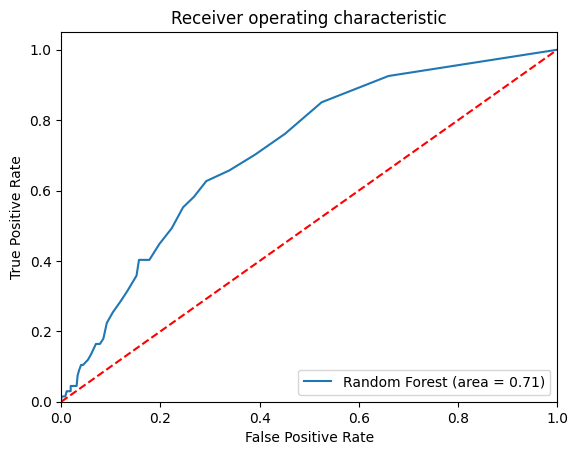

In [ ]:
# Random Forest
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Boosted tree

In [ ]:
# Boosted tree model

from sklearn.ensemble import AdaBoostClassifier

bt_model = AdaBoostClassifier(n_estimators=100)

bt_model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100)

In [ ]:
y_pred_bt = bt_model.predict(X_test)

confusion_matrix(y_test,y_pred_bt)

array([[997,   5],
       [ 66,   1]])

In [ ]:
print(classification_report(y_test,y_pred_bt))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1002
           1       0.17      0.01      0.03        67

    accuracy                           0.93      1069
   macro avg       0.55      0.50      0.50      1069
weighted avg       0.89      0.93      0.91      1069



In [ ]:
from sklearn.metrics import roc_auc_score

print('ROC AUC: ', roc_auc_score(y_test,y_pred))

ROC AUC:  0.5


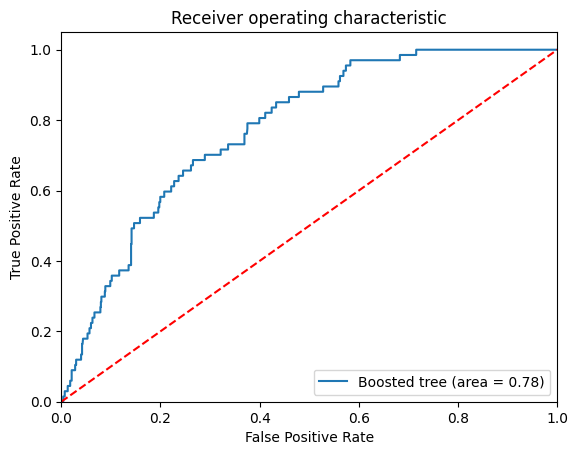

In [ ]:
bt_roc_auc = roc_auc_score(y_test, bt_model.predict_proba(X_test)[:,1])
bt_fpr, bt_tpr, bt_thresholds = roc_curve(y_test, bt_model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(bt_fpr, bt_tpr, label='Boosted tree (area = %0.2f)' % bt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Naive Bayes

In [ ]:
stroke_nb = MultinomialNB(alpha=0.01)
stroke_nb.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [ ]:
y_pred_proba = stroke_nb.predict_proba(X_test)

# Choose a threshold (e.g., 0.05) to classify instances
threshold = 0.05

# Apply threshold to predict classes
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[642 360]
 [ 19  48]]
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1002
           1       0.12      0.72      0.20        67

    accuracy                           0.65      1069
   macro avg       0.54      0.68      0.49      1069
weighted avg       0.92      0.65      0.74      1069



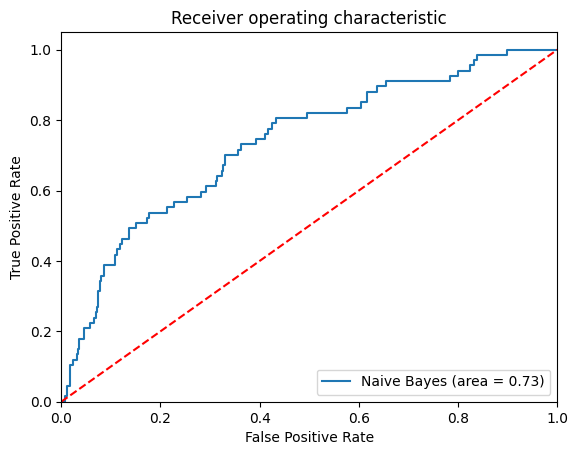

In [ ]:
nb_roc_auc = roc_auc_score(y_test, stroke_nb.predict_proba(X_test)[:,1])
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, stroke_nb.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!pip install -- eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107721 sha256=bd2ce1be64d1e20e80e1e011479c511963bc1cac53027083029ebda81111d72b
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# Assuming you have your feature matrix X_test and the trained classifier stroke_nb

# Fit permutation importance
perm = PermutationImportance(stroke_nb, random_state=1).fit(X_test, y_test)

# Show weights
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

# Check for zero weights
zero_weight_features = []
for feature, weight in zip(X_test.columns, perm.feature_importances_):
    if weight == 0:
        zero_weight_features.append(feature)

# Print features with zero weights
print("Features with zero weights:", zero_weight_features)


ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(stroke_nb, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In this analysis, we're employing a Random Forest (RF) model instead of Naive Bayes due to encountering zero weights in the permutation importance analysis with the latter. Random Forest is a robust ensemble learning technique that amalgamates numerous decision trees to generate predictions. By training on the given dataset, the RF model discerns relationships between features and the target variable, thus attributing importance scores to each feature based on its impact on prediction accuracy. The permutation importance analysis, conducted using the RF model, evaluates the effect of shuffling each feature on the model's performance, thereby unveiling the relative significance of features in prediction. This approach aids in pinpointing pivotal features that substantially influence the model's decisions, facilitating the interpretation and comprehension of the underlying data dynamics.

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

###**Highly Influential Features:**

heart_disease (0.0019 ± 0.0000): Slight positive influence on Stroke.

avg_glucose_level (0.0013 ± 0.0039): Minor positive influence.

smoking_status_smokes (0.0009 ± 0.0024): Slight positive influence.
###**Moderately Influential Features:**

hypertension (0.0002 ± 0.0007): Negligible positive influence.

ever_married_Yes (0.0002 ± 0.0014): Minor positive influence.
###**Minor Influential Features:**

Several features, such as
work_type_Never_worked,gender_Other,bmi,age,work_type_children,smoking_status_never,,ever_married_No,gender_Male,work_type_Private,work_type_Govt_jobuggesting a minor influence on the stroke
.
###**Negligible Influence:**

gender_Female (-0.0006 ± 0.0009): Minor negative influence.

work_type_Self-employed (-0.0022 ± 0.0009): Noticeable negative influence.

####**In summary, the model suggests that factors like heart_disease,avg_glucose_level,smoking_status_smokes carry notable weight in determining prediction of stroke, while other features play a comparatively lesser role in the decision-making process.**

In [ ]:
x_y = pd.concat([X_test,y_test], axis=1)

sns.pairplot(x_y[['heart_disease','avg_glucose_level','smoking_status_smokes','hypertension','ever_married_Yes','stroke']], hue='stroke')

# ANN Classification

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
strokedetection.shape

In [ ]:
MLPC_model = MLPClassifier(hidden_layer_sizes= 21, activation='logistic', solver='adam', random_state=1)

MLPC_model.fit(X_train, y_train)

In [ ]:
y_pred_proba = MLPC_model.predict_proba(X_test)

# Choose a threshold (e.g., 0.05) to classify instances
threshold = 0.05

# Apply threshold to predict classes
y_pred_mlpc = (y_pred_proba[:, 1] >= threshold).astype(int)

print(confusion_matrix(y_test,y_pred_mlpc))
print(classification_report(y_test,y_pred_mlpc))

In [ ]:
print('ROC AUC: ', roc_auc_score(y_test,MLPC_model.predict_proba(X_test)[:,1]))

In [ ]:
from sklearn.model_selection import cross_val_score
min_hidden_layer_size = 5
max_hidden_layer_size = 30
cv_scores = [ ]

for s in range(min_hidden_layer_size,max_hidden_layer_size,5):
    MLPC_model = MLPClassifier(hidden_layer_sizes=s, activation='logistic', solver='adam', max_iter=1000, learning_rate_init= 0.01, random_state=1)
    scores = cross_val_score(MLPC_model,X_train,y_train.values.ravel(),cv = 5,scoring = "roc_auc")
    cv_scores.append(scores.mean())

We introduced the max_iter parameter in response to convergence warnings encountered during the training process. Initially, we set max_iter to 100, but even after incrementally increasing it up to 900, the convergence warnings persisted. Consequently, we made the decision to further extend the maximum number of iterations to 1000. This adjustment was made to provide the MLPClassifier with an ample training duration, allowing it additional iterations to converge to a stable solution. By setting max_iter=1000, we aimed to effectively address the convergence issues observed earlier and ensure the model's reliability and predictive accuracy. Monitoring the training process closely enabled us to make informed decisions regarding the max_iter parameter and optimize the MLPClassifier's performance while mitigating convergence concerns.

In [ ]:
sns.lineplot(x=range(min_hidden_layer_size,max_hidden_layer_size,5), y=cv_scores)

In [ ]:
max_Roc_auc = max(cv_scores)  # Find the maximum Roc_auc
optimal_hidden_nodes = range(min_hidden_layer_size, max_hidden_layer_size, 5)[cv_scores.index(max_Roc_auc)]  # Find the corresponding number of hidden nodes

print("Maximum Roc_auc:", max_Roc_auc)
print("Number of Hidden Nodes for Maximum Roc_auc:", optimal_hidden_nodes)

In [ ]:
MLPC_model = MLPClassifier(hidden_layer_sizes=5, activation='logistic', solver='adam', random_state=1)

MLPC_model.fit(X_train, y_train)

y_pred_proba = MLPC_model.predict_proba(X_test)

# Choose a threshold (e.g., 0.05) to classify instances
threshold = 0.05

# Apply threshold to predict classes
y_pred_mlpc = (y_pred_proba[:, 1] >= threshold).astype(int)

print(confusion_matrix(y_test,y_pred_mlpc))
print(classification_report(y_test,y_pred_mlpc))

In [ ]:
print('ROC AUC: ', roc_auc_score(y_test,MLPC_model.predict_proba(X_test)[:,1]))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

MLPC_roc_auc = roc_auc_score(y_test, MLPC_model.predict_proba(X_test)[:,1])
mlpc_fpr, mlpc_tpr, thresholds = roc_curve(y_test, MLPC_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(mlpc_fpr, mlpc_tpr, label='ANN-MLP Classifier (area = %0.2f)' % MLPC_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of MLP Classifier Model')
plt.legend(loc="lower right")
plt.savefig('MLPC_ROC')
plt.show()

**ROC AUC Curve Coefficient**: Although the ROC AUC curve coefficient  decreases from 0.75 to 0.74 after reducing the number of nodes to 5, it still indicates very high discriminatory power of the model in distinguishing between classes.

# Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
X_train.shape

In [ ]:
keras_model = Sequential()

keras_model.add(Dense(units=100,activation='relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(units=50,activation='relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(units=25,activation='relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(units=1, activation='sigmoid'))
# For a binary classification problem
keras_model.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
keras_model.fit(x=X_train,
          y=y_train,
          batch_size=128,
          epochs=200,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

In [ ]:
model_loss = pd.DataFrame(keras_model.history.history)
model_loss.plot()

In [ ]:
y_pred= keras_model.predict(X_test)

In [ ]:
y_pred[:5]

In [ ]:
y_pred =(keras_model.predict(X_test) > 0.1).astype("int32")

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
print(confusion_matrix(y_test,y_pred))
print('ROC AUC: ', roc_auc_score(y_test,keras_model.predict(X_test)))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC AUC score
Keras_roc_auc = roc_auc_score(y_test, keras_model.predict(X_test))

# Compute ROC curve
k_fpr, k_tpr, thresholds = roc_curve(y_test, keras_model.predict(X_test))

# Plot ROC curve
plt.figure()
plt.plot(k_fpr, k_tpr, label='Keras ROC curve (area = %0.2f)' % Keras_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Keras (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Final ROC AUC Curve

In [ ]:
# Random Forest
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])

# Boosted Tree
bt_roc_auc = roc_auc_score(y_test, bt_model.predict_proba(X_test)[:,1])
bt_fpr, bt_tpr, bt_thresholds = roc_curve(y_test, bt_model.predict_proba(X_test)[:,1])

# kNN Model
kNN_roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

# Logistic Regression
logit_roc_auc = roc_auc_score(y_test, logmodel.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])

# Naive bayes
nb_roc_auc = roc_auc_score(y_test, stroke_nb.predict_proba(X_test)[:,1])
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, stroke_nb.predict_proba(X_test)[:,1])

#ANN Model
MLPC_roc_auc = roc_auc_score(y_test, MLPC_model.predict_proba(X_test)[:,1])
mlpc_fpr, mlpc_tpr, thresholds = roc_curve(y_test, MLPC_model.predict_proba(X_test)[:,1])

#Keras Model
Keras_roc_auc = roc_auc_score(y_test, keras_model.predict(X_test))
k_fpr, k_tpr, thresholds = roc_curve(y_test, keras_model.predict(X_test))

plt.figure(figsize=(10, 10))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(bt_fpr, bt_tpr, label='Boosted tree (area = %0.2f)' % bt_roc_auc)
plt.plot(knn_fpr, knn_tpr, label='KNN (area = %0.2f)' % kNN_roc_auc)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes (area = %0.2f)' % nb_roc_auc)
plt.plot(k_fpr, k_tpr, label='Keras ROC curve (area = %0.2f)' % Keras_roc_auc)
plt.plot(mlpc_fpr, mlpc_tpr, label='ANN-MLP Classifier (area = %0.2f)' % MLPC_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### **Assessing the performance of each model using the following metrics:**
### **Recall, Precision, F1, ROC AUC:

### **Logistic Model:**
- **Stroke (1) Prediction:** The Logit Model demonstrates a low precision of 0.14, meaning that out of all instances predicted as strokes, only 14% are actually strokes. It shows a lower recall of 0.72, indicating that it captures 72% of actual stroke cases.
- **No Stroke (0) Prediction:** For non-stroke cases, the Logit Model exhibits high precision (0.97) but lower recall (0.72). This means that while it correctly identifies most instances as non-stroke, it misses identifying some actual stroke cases.
- **Overall Performance:** The model achieves an accuracy of 0.79, suggesting it performs moderately well overall.

### **KNN Model:**
- **Stroke (1) Prediction:** The KNN Model performs poorly in predicting strokes, with both precision and recall being 0.00. This indicates that it fails to correctly identify any actual stroke cases.
- **No Stroke (0) Prediction:** However, for non-stroke cases, the model shows high precision (0.94) and recall (1.00), meaning it accurately identifies non-stroke instances.
- **Overall Performance:** At an accuracy of 0.71, the model's inability to predict strokes makes its overall performance questionable.

### **Random Forest Model:**
- **Stroke (1) Prediction:** The Random Forest Model demonstrates better performance in predicting strokes compared to the KNN Model, with a precision of 0.33 and recall of 0.01. Although the precision is low, it manages to capture some stroke cases.
- **No Stroke (0) Prediction:** Similar to other models, it performs well in predicting non-stroke cases, with high precision (0.94) and recall (1.00).
- **Overall Performance:** With an accuracy of 0.71, the Random Forest Model offers a poor performance, with limitations in predicting strokes.

### **Boosted Tree Model:**
- **Stroke (1) Prediction:** The Boosted Tree Model, like the Random Forest Model, shows improved performance in predicting strokes compared to KNN, with a precision of 0.17 and recall of 0.01. It captures some stroke cases but also has limitations.
- **No Stroke (0) Prediction:** It excels in predicting non-stroke cases with high precision (0.94) and recall (1.00).
- **Overall Performance:** With an accuracy of 0.78, the Boosted Tree Model performs decently, but its ability to predict strokes is limited.

### **Naive Bayes Model:**
- **Stroke (1) Prediction:**
  - Precision: The model correctly identifies 0% of instances predicted as "Stroke" out of all instances predicted as such.
  - Recall: 0% of actual "Stroke" instances are captured by the model out of all true "Stroke" instances.
  - F1-score: The F1-score for "Stroke" prediction is at 0.02, indicating poor overall performance in identifying strokes.

- **No Stroke (0) Prediction:**
  - Precision: 94% of instances predicted as "No Stroke" are actually "No Stroke."
  - Recall: All actual instances of "No Stroke" are correctly identified by the model.
  - F1-score: The F1-score for "No Stroke" prediction is high at 0.97, reflecting strong performance in identifying non-stroke cases.

- **Overall Performance:**
  - The model's overall accuracy is 73%, showing the proportion of correctly predicted instances across both classes.
  - The macro-average F1-score is 0.48, indicating slightly unbalanced performance measure across both classes.

In summary, the Naive Bayes model performs well in identifying non-stroke cases but struggles significantly in correctly predicting instances of stroke. This imbalance in performance underscores the need for improvement, particularly in enhancing the model's ability to identify stroke cases.

### **ANN Model:**

- **No Stroke (0) Prediction:**
  - **Precision (0.97)**: Out of all instances predicted as "No Stroke," 97% were actually "No Stroke." This indicates a high proportion of true negative predictions among all instances predicted as negative.
  - **Recall (0.64)**: Of all actual "No Stroke" instances, the model correctly identified 64% of them. This means that the model captured 64% of all occurrences of "No Stroke."
  - **F1-score (0.77)**: The F1-score for predicting "No Stroke" is 77%, which is the harmonic mean of precision and recall. It balances the trade-off between precision and recall, providing a single measure of the model's performance for class 0.

- **Stroke (1) Prediction:**
  - **Precision (0.10)**: Only 10% of instances predicted as "Stroke" were actually "Stroke." This indicates a low proportion of true positive predictions among all instances predicted as positive.
  - **Recall (0.73)**: The model identified 73% of all actual "Stroke" cases. This means that the model captured 73% of all occurrences of "Stroke."
  - **F1-score (0.18)**: The F1-score for predicting "Stroke" is 18%, indicating the balance between precision and recall for class 1.

- **Overall**:
  - **Accuracy (0.59)**: The model correctly classified 59% of all instances, regardless of class imbalance.

### **Keras Model:**

- **No Stroke (0) Prediction:**
  - **Precision (0.96)**: The model correctly identifies 96% of instances predicted as "No Stroke" out of all instances predicted as such. This indicates a high proportion of true negative predictions among all instances predicted as negative.
  - **Recall (0.83)**: Of all actual "No Stroke" instances, the model correctly identifies 83% of them. This means that the model captured 83% of all occurrences of "No Stroke."
  - **F1-score (0.89)**: The F1-score for predicting "No Stroke" is 89%, which is the harmonic mean of precision and recall. It reflects a balance between precision and recall for class 0.

- **Stroke (1) Prediction:**
  - **Precision (0.15)**: Only 15% of instances predicted as "Stroke" were actually "Stroke." This indicates a relatively low proportion of true positive predictions among all instances predicted as positive.
  - **Recall (0.46)**: The model identified 46% of all actual "Stroke" cases. This means that the model captured 46% of all occurrences of "Stroke."
  - **F1-score (0.23)**: The F1-score for predicting "Stroke" is 23%, indicating the balance between precision and recall for class 1.

- **Overall**:
  - **Accuracy (0.81)**: The model correctly classified 81% of all instances, regardless of class imbalance.
  
### **Inferences on Classification Results:**
- **Precision**: Random Forest Model have the highest precision for predicting strokes, with a precision of 0.17.
- **Recall**: The ANN Model (MLP Classifier) has the highest recall score for predicting strokes, with a recall of 0.73.
- **F1 Score**: The Keras Model has the highest F1 score for predicting strokes, with an F1 score of 0.23.
- **Accuracy**: Keras Model has the highest accuracy of 0.81, indicating that it correctly classifies 81% of all instances, regardless of class imbalance.

### **Conclusion:**

Overall, based on ROC AUC, the Logistics Regression model stands out as the best performer for determining the prediction of stroke. Its higher precision and ROC AUC suggest that it is more reliable in correctly identifying having chances of getting stroke. However, the Logistics Regression model's higher recall and F1-score indicate that it may be better at capturing more true positive instances while maintaining a reasonable balance between precision and recall.